# ECG-Pytorch-Quantization Compression

@create 2021-09-13
@author 孙寒石
@env Pytorch 1.9.0 Python 3.7

## Import Packages

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Prepare Dataset

In [2]:
import os
import scipy.io as scio
from sklearn.model_selection import train_test_split

base_path = './'
dataset_path =  './Dataset' # Training data

classes = ['NSR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW','PVC', 'Bigeminy', 'Trigeminy', 
           'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB', 'PR']
ClassesNum = len(classes)

X = list()
y = list()

for root, dirs, files in os.walk(dataset_path, topdown=False):
    for name in files:
        data_train = scio.loadmat(os.path.join(root, name))# 取出字典里的value
        
        # arr -> list
        data_arr = data_train.get('val')
        data_list = data_arr.tolist()
        
        X.append(data_list[0]) # [[……]] -> [ ]
        y.append(int(os.path.basename(root)[0:2]) - 1)  # name -> num
        
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
        

X=np.array(X)
y=np.array(y)
X = X.reshape((1000,1,3600))
y = y.reshape((1000))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print("X_train : ", len(X_train))
print("X_test  : ", len(X_test))
print("shape of X_train : ", np.shape(X_train[0]))
print("shape of y_train : ", np.shape(y_train))
print("shape of X_test : ", np.shape(X_test))
print("shape of y_test : ", np.shape(y_test))

X_train :  700
X_test  :  300
shape of X_train :  (1, 3600)
shape of y_train :  (700,)
shape of X_test :  (300, 1, 3600)
shape of y_test :  (300,)


In [24]:
batch_size = 32
class MyDataset(Dataset):
    def __init__(self):
        self.len = X_train.shape[0] # 取第0元素：长度
        self.x_train = torch.from_numpy(X_train).float()
        self.y_train = torch.from_numpy(y_train).long()
    def __getitem__(self, index):
        return self.x_train[index], self.y_train[index] # 返回对应样本即可
    def __len__(self):
        return self.len
    
class TestDataset(Dataset):
    def __init__(self):
        self.len = X_test.shape[0] # 取第0元素：长度
        self.x_test = torch.from_numpy(X_test).float()
        self.y_test = torch.from_numpy(y_test).long()
    def __getitem__(self, index):
        return self.x_test[index], self.y_test[index] # 返回对应样本即可
    def __len__(self):
        return self.len    
        
train_dataset = MyDataset()
test_dataset = TestDataset()
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)
test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          num_workers=0)

## Design Model

In [25]:
num_epochs = 100
log_interval = 10
in_channels_ = 1
num_segments_in_record = 100
segment_len = 3600   # 3600 采样
num_records = 48
num_classes = 17

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class arrhythmia_classifier(nn.Module):
    def __init__(self, in_channels=in_channels_):
        super(arrhythmia_classifier, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1,8,16),
            nn.ReLU(),
            nn.BatchNorm1d(8),
            nn.MaxPool1d(kernel_size=8),
   
            nn.Conv1d(8,16,9),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.MaxPool1d(4),
            
            nn.Conv1d(16,32,9),
            nn.ReLU(),
            nn.MaxPool1d(4,stride=2),
            
            nn.Conv1d(32,64,7),
            nn.ReLU(),
            nn.MaxPool1d(4,stride=1),
            
            nn.Conv1d(64,64,5),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            nn.Conv1d(64,64,3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            
            nn.Conv1d(64,72,3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            Flatten(),
            nn.Linear(in_features=216, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=17),
        )

    def forward(self, x, ex_features=None):
        return self.cnn(x)


def calc_next_len_conv1d(current_len=112500, kernel_size=16, stride=8, padding=0, dilation=1):
    return int(np.floor((current_len + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1))
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = arrhythmia_classifier().to("cpu")

In [26]:
print(model)

arrhythmia_classifier(
  (cnn): Sequential(
    (0): Conv1d(1, 8, kernel_size=(16,), stride=(1,))
    (1): ReLU()
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(8, 16, kernel_size=(9,), stride=(1,))
    (5): ReLU()
    (6): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(16, 32, kernel_size=(9,), stride=(1,))
    (9): ReLU()
    (10): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv1d(32, 64, kernel_size=(7,), stride=(1,))
    (12): ReLU()
    (13): MaxPool1d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
    (14): Conv1d(64, 64, kernel_size=(5,), stride=(1,))
    (15): ReLU()
    (16): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [27]:
#from torchsummary import summary
#summary(model, input_size=(1, 3600))

## Construct Loss and Optimizer

In [28]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0007, betas=(0.9, 0.999), eps=1e-08, weight_decay = 0.0, amsgrad = False)

## Train

In [38]:
correct_list = []
def train(epoch):
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target = data
        optimizer.zero_grad()
        # forward + backward + update
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 10 == 9:
            print('[%d, %5d] loss: %.8f' % (epoch + 1, batch_idx + 1, running_loss / 300))
            running_loss = 0.0


def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    correct_list.append(100 * correct / total)
    print('Accuracy on test set: %d %%' % (100 * correct / total))
    
    
for epoch in range(300):
    train(epoch)
    test()

[1,    10] loss: 0.00006999
[1,    20] loss: 0.00004558
Accuracy on test set: 83 %
[2,    10] loss: 0.00006956
[2,    20] loss: 0.00007480
Accuracy on test set: 81 %
[3,    10] loss: 0.00053108
[3,    20] loss: 0.00027166
Accuracy on test set: 79 %
[4,    10] loss: 0.00022295
[4,    20] loss: 0.00007665
Accuracy on test set: 81 %
[5,    10] loss: 0.00005595
[5,    20] loss: 0.00010476
Accuracy on test set: 82 %
[6,    10] loss: 0.00007868
[6,    20] loss: 0.00005181
Accuracy on test set: 82 %
[7,    10] loss: 0.00002314
[7,    20] loss: 0.00003909
Accuracy on test set: 79 %
[8,    10] loss: 0.00002494
[8,    20] loss: 0.00006790
Accuracy on test set: 82 %
[9,    10] loss: 0.00002527
[9,    20] loss: 0.00005088
Accuracy on test set: 82 %
[10,    10] loss: 0.00004301
[10,    20] loss: 0.00003129
Accuracy on test set: 81 %
[11,    10] loss: 0.00004638
[11,    20] loss: 0.00002508
Accuracy on test set: 82 %
[12,    10] loss: 0.00004466
[12,    20] loss: 0.00002746
Accuracy on test set: 82 

[98,    10] loss: 0.00001809
[98,    20] loss: 0.00001953
Accuracy on test set: 81 %
[99,    10] loss: 0.00001216
[99,    20] loss: 0.00001462
Accuracy on test set: 81 %
[100,    10] loss: 0.00001678
[100,    20] loss: 0.00000934
Accuracy on test set: 81 %
[101,    10] loss: 0.00000818
[101,    20] loss: 0.00001498
Accuracy on test set: 82 %
[102,    10] loss: 0.00000889
[102,    20] loss: 0.00002653
Accuracy on test set: 82 %
[103,    10] loss: 0.00001814
[103,    20] loss: 0.00000661
Accuracy on test set: 81 %
[104,    10] loss: 0.00001132
[104,    20] loss: 0.00000788
Accuracy on test set: 82 %
[105,    10] loss: 0.00000650
[105,    20] loss: 0.00001536
Accuracy on test set: 81 %
[106,    10] loss: 0.00001232
[106,    20] loss: 0.00000648
Accuracy on test set: 81 %
[107,    10] loss: 0.00001066
[107,    20] loss: 0.00000749
Accuracy on test set: 81 %
[108,    10] loss: 0.00001362
[108,    20] loss: 0.00000948
Accuracy on test set: 81 %
[109,    10] loss: 0.00000652
[109,    20] loss

Accuracy on test set: 81 %
[193,    10] loss: 0.00000224
[193,    20] loss: 0.00000136
Accuracy on test set: 81 %
[194,    10] loss: 0.00000076
[194,    20] loss: 0.00000187
Accuracy on test set: 81 %
[195,    10] loss: 0.00000177
[195,    20] loss: 0.00000060
Accuracy on test set: 82 %
[196,    10] loss: 0.00000080
[196,    20] loss: 0.00000105
Accuracy on test set: 80 %
[197,    10] loss: 0.00000048
[197,    20] loss: 0.00000086
Accuracy on test set: 82 %
[198,    10] loss: 0.00000084
[198,    20] loss: 0.00000077
Accuracy on test set: 81 %
[199,    10] loss: 0.00000082
[199,    20] loss: 0.00000058
Accuracy on test set: 82 %
[200,    10] loss: 0.00000103
[200,    20] loss: 0.00000062
Accuracy on test set: 81 %
[201,    10] loss: 0.00000066
[201,    20] loss: 0.00000098
Accuracy on test set: 80 %
[202,    10] loss: 0.00000049
[202,    20] loss: 0.00000071
Accuracy on test set: 81 %
[203,    10] loss: 0.00000065
[203,    20] loss: 0.00000049
Accuracy on test set: 82 %
[204,    10] los

[287,    20] loss: 0.00000211
Accuracy on test set: 82 %
[288,    10] loss: 0.00000647
[288,    20] loss: 0.00000578
Accuracy on test set: 81 %
[289,    10] loss: 0.00000324
[289,    20] loss: 0.00000217
Accuracy on test set: 81 %
[290,    10] loss: 0.00000160
[290,    20] loss: 0.00000307
Accuracy on test set: 81 %
[291,    10] loss: 0.00000235
[291,    20] loss: 0.00000200
Accuracy on test set: 79 %
[292,    10] loss: 0.00000166
[292,    20] loss: 0.00000262
Accuracy on test set: 81 %
[293,    10] loss: 0.00002967
[293,    20] loss: 0.00000821
Accuracy on test set: 79 %
[294,    10] loss: 0.00003343
[294,    20] loss: 0.00000213
Accuracy on test set: 80 %
[295,    10] loss: 0.00000388
[295,    20] loss: 0.00000224
Accuracy on test set: 80 %
[296,    10] loss: 0.00000293
[296,    20] loss: 0.00000410
Accuracy on test set: 80 %
[297,    10] loss: 0.00000317
[297,    20] loss: 0.00000275
Accuracy on test set: 79 %
[298,    10] loss: 0.00000396
[298,    20] loss: 0.00000180
Accuracy on t

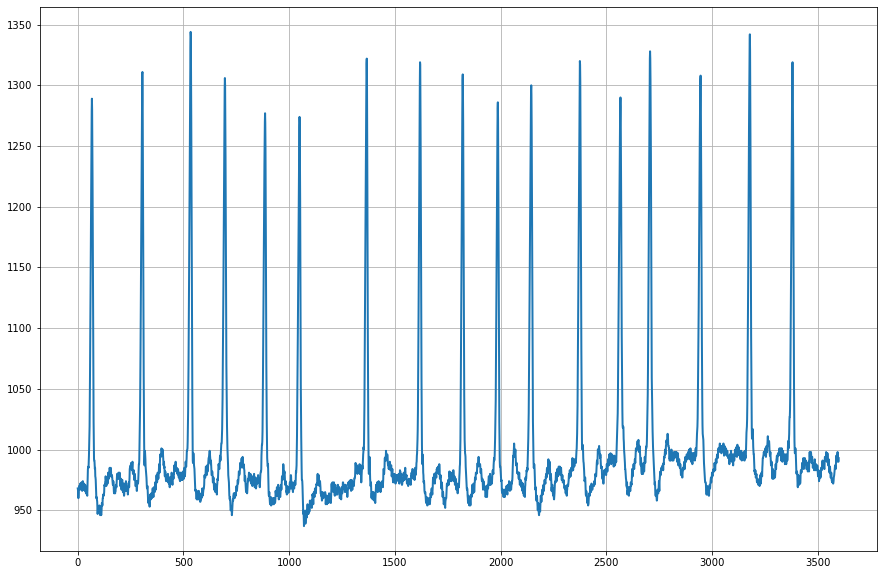

In [39]:
t=np.arange(3600)
p = X_train[1,:,:].reshape((3600))
plt.plot(t,p)

In [40]:
correct = 0
total = 0
with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            print(predicted)
            print(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
print('Accuracy on test set: %d %%' % (100 * correct / total))

tensor([ 3,  0, 14,  0,  6,  0,  7,  7, 13,  0,  0,  3,  3, 14, 16,  6,  3, 13,
        16,  0,  0,  2,  7,  6,  6,  6,  6, 10,  0,  1,  1,  3])
tensor([ 3,  0, 14,  1, 14,  0,  7,  7, 13,  6,  0,  3,  3, 14, 16,  6,  3, 13,
        16,  0,  0,  8, 11,  8,  0,  6,  6, 10,  0,  1,  4,  3])
tensor([14,  0,  6,  0,  8,  0,  6,  3,  0, 14,  0, 10, 12,  6,  8,  6, 13,  0,
         0,  6,  7,  6,  0,  0, 13,  6,  6,  0,  3,  3,  0,  0])
tensor([14,  0,  1,  0,  7,  0,  6,  3,  0, 14,  0, 10, 12,  6,  8,  6, 13,  0,
         0,  6,  7,  6,  0,  0, 13,  6,  6,  0,  3,  3,  0,  0])
tensor([ 0,  3,  0,  1, 14,  6, 16, 10,  0, 11,  7,  6,  0,  0,  3,  0,  0,  6,
        13,  7,  0,  6,  3,  7, 14,  0,  5, 15,  0,  1,  0,  3])
tensor([ 0,  3,  0,  0, 14,  6, 16, 10,  0, 11,  7,  6,  0,  0,  3,  0,  0,  6,
        13,  7,  0,  1,  3,  7, 14,  0,  5, 15,  0,  1,  0,  3])
tensor([ 1,  0,  3, 12,  2, 15,  0,  6,  7, 13,  3,  3,  6, 14,  0, 15,  7, 13,
         2, 13, 13, 14,  7,  6,  6,  3, 15,  0,  6

In [41]:
y_test

array([ 3,  0, 10,  1,  3, 13,  6,  7,  0,  0,  2, 10,  3,  7,  2,  0, 13,
        3,  0,  3,  4,  3,  3, 12,  0,  0,  6,  3, 13,  0,  4,  8,  6,  0,
        0,  0, 14,  0, 16, 13,  8,  3, 16, 13,  0,  3, 14, 14,  3,  6,  0,
        6,  0,  5,  1,  0, 14,  5,  6,  7,  2, 12,  0,  6,  2, 15,  6, 13,
        6,  6, 14,  1,  0,  7,  7,  0,  7,  3,  6,  3, 14,  1,  0,  6,  6,
        2,  4,  3,  3,  1, 11,  6,  1, 13,  0,  0,  1,  0,  0, 13,  3,  1,
        3,  7,  4,  5,  3,  1, 13,  6, 12,  6, 14,  3,  3,  3, 13,  6, 11,
        0, 15,  6, 14, 14,  3,  0,  8,  0,  7,  0,  6,  0,  3,  3,  1, 14,
        1,  0,  2,  0, 13,  0, 13, 14, 14,  3,  0, 13, 15,  3, 13,  6,  1,
        3,  0, 13, 13, 13,  7,  6, 13,  3, 16, 14,  0,  6,  7,  0, 13,  0,
        0,  0,  6,  1,  6,  0,  4,  0,  0, 10,  0,  1,  8, 13,  0, 16, 13,
        0,  0,  0,  6,  3,  6,  3,  0, 16,  0,  6, 10, 13, 14,  6, 14, 15,
        7,  0,  0,  2,  3,  7,  0,  0,  6,  3,  6,  7,  1,  0, 13,  0,  3,
       15,  1,  0,  7,  7

Text(0, 0.5, 'Accuracy(%)')

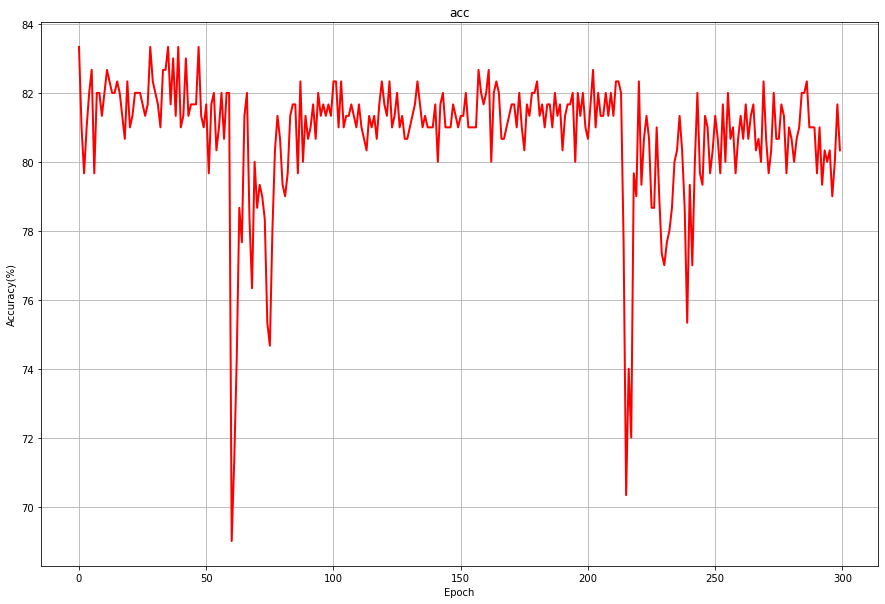

In [42]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True
plt.plot(correct_list,'r')
plt.title('acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')

In [19]:
y_train

array([ 0,  0,  0,  1, 13, 13, 16,  3, 13,  0,  3,  6, 16,  0,  0,  6,  3,
        0, 15,  5,  0, 14, 14,  0,  2, 13, 14, 16,  3, 11,  0, 10,  6, 14,
        7,  3,  0, 15,  1, 13, 14,  9,  1,  3,  2,  5,  0,  3,  7, 14,  7,
       13,  5,  1, 14,  0, 15,  3, 10,  3, 13,  0,  0, 13,  7, 13,  6,  6,
        6,  7,  8,  1,  0,  0,  3,  0,  0,  1, 13,  0,  0,  1,  0,  3, 14,
       13,  3,  6,  1,  6, 14,  0,  2,  0,  3,  0,  9,  1,  0,  3,  1, 13,
        3, 13,  7,  0, 13,  0,  1,  1,  0, 14,  3, 14,  2,  3, 14, 13,  0,
       13, 13,  3, 13,  6,  3, 13,  0,  7, 16, 14,  0, 14, 13,  9,  3,  0,
        3, 13, 12,  1,  6,  5,  0,  6, 14,  3, 16,  0, 13,  2,  6, 15,  3,
        0,  6,  2,  3, 13,  6,  3,  0,  6, 16,  0,  0,  0,  8,  5,  3,  6,
        3, 13, 14,  7,  0, 15,  1,  3,  1,  5,  3,  3,  7, 14, 16,  4,  0,
       13,  0,  0,  6,  7,  0,  0,  6,  0,  0,  3,  7,  7,  3,  0,  1,  0,
       13, 11, 12,  0,  0,  4,  3,  7,  6, 13, 13,  0,  0,  3,  6,  0,  3,
       13, 16,  0,  6, 16